In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os 
import seaborn as sns
sns.set_context('talk')

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
save_path = 'G:/My Drive/WORKING_MEMORY/PAPER/ANALYSIS_figures/'
os.chdir(save_path)
file_name = 'logodds_singletrial_V11_sti'
df_cum_sti = pd.read_csv(file_name+'.csv', index_col = 0)

# save_path = 'G:/Mi unidad/WORKING_MEMORY/PAPER/ANALYSIS_figures/'
# os.chdir(save_path)
# file_name = 'logodds_singletrial_V11'
# df_cum_sti.to_csv(file_name+'_sti.csv')

In [ ]:
# df_cum_sti = df_cum_sti[~df_cum_sti['session'].isin(list_exclude)] 
fig, axs = plt.subplots(2,2, figsize=(12, 8))
for delay, ax in zip([1,3,10], axs.flatten()):
    df_final = df_cum_sti.loc[(df_cum_sti.delay==delay)].groupby(['session','times','trial_type'])['log_odds'].mean()
    df_final = df_final.reset_index()
    sns.lineplot(x='times',y='log_odds',data= df_final, hue='trial_type', palette=['darkorange', 'purple',  'crimson','darkgreen'], ax=ax, errorbar=None)
    plt.xlim(-2,delay+6)
    plt.ylim(-2,3)
sns.despine()
plt.show()

In [ ]:
with PdfPages('G:/My Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/ANALYSIS/results/log_odds_trials.pdf') as pdf:
    for session in df_cum_sti.session.unique():
        for trial in df_cum_sti.loc[(df_cum_sti.session == session)].trial.unique():
            fig, ax = plt.subplots(1,1, figsize=(6, 4))
            df_final = df_cum_sti.loc[(df_cum_sti.session == session)&(df_cum_sti.trial == trial)].groupby(['times', 'trial_type']).agg({'log_odds':'mean', 
                                                                                                                                'delay':'mean', 
                                                                                                                                }).reset_index()
            df_final = df_final.reset_index()
            delay = df_final.delay.unique()[0]
            trial_type = df_final.trial_type.unique()[0]
            sns.lineplot(x='times',y='log_odds',data= df_final, ax=ax)
            ax.axvspan(0, 0.2, color='gray', alpha=0.2)
            ax.axvspan(delay, delay+0.2, color='lightgray', alpha=0.2)

            ax.hlines(0, -2, delay+4, linestyle='--', color='black')
            sns.despine()
            try:
                plt.xlim(-2,delay+4)
            except:
                delay = 10
                plt.xlim(-2,delay+4)
            plt.title('Session: '+str(session[:-13])+' Trial: '+str(trial)+ ' \n Delay: '+ str(delay)+ ' Trial type: '+str(trial_type))
            # plt.yl(im(-2,3)
            # plt.show()
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close()


## Recover specific reversals and plot them aligned to the onset of reversal

In [136]:
path = r'E:\Ephys\neurons_log_odds.csv'
df_neurons = pd.read_csv(path)

save_path = 'G:/My Drive/WORKING_MEMORY/PAPER/ANALYSIS_figures/'
os.chdir(save_path)
file_name = 'final_log_dds_fulltrial'
df_cum_sti = pd.read_csv(file_name+'.csv', index_col = 0)
df_cum_sti['short_session'] = df_cum_sti['session'].str[:-13]
df_cum_sti.drop(columns='session', inplace=True)
df_cum_sti.rename(columns={'short_session':'session'}, inplace=True)

In [137]:
# Initialize an empty DataFrame to store the filtered results
filtered_df = pd.DataFrame()

# Iterate through each row in df_filter
for _, row in df_neurons.iterrows():
    # Filter df_neurons where both columns match the current row in df_filter
    temp_df = df_cum_sti[
        (df_cum_sti['session'] == row['session']) &
        (df_cum_sti['trial'] == row['trial'])
    ]
    # Append the filtered results to filtered_df
    filtered_df = pd.concat([filtered_df, temp_df])

In [ ]:
trial = pd.merge(df_neurons, df_cum_sti, on=['session', 'trial'])
df_neurons = trial.groupby(['session','trial', 'delay']).log_odds.mean().reset_index()

reversals = df_neurons.groupby(['session', 'delay']).trial.nunique().reset_index()
reversals.rename(columns={'trial':'reversals'}, inplace=True)

summary = df_cum_sti.loc[df_cum_sti.trial_type == 'WM_roll_0'].groupby(['session', 'delay']).trial.nunique().reset_index()
summary = summary.merge(reversals, on=['session', 'delay'], how='outer')
summary['reversals'] = summary['reversals'].fillna(0)
summary['fraction'] = (summary['reversals']/summary['trial'])*100

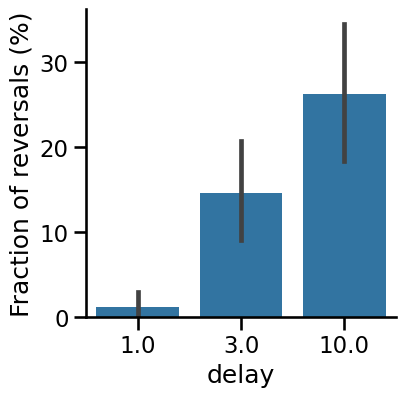

In [148]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
sns.barplot(x='delay', y='fraction', data=summary)
plt.ylabel('Fraction of reversals (%)')
sns.despine()

<Axes: xlabel='delay', ylabel='trial'>

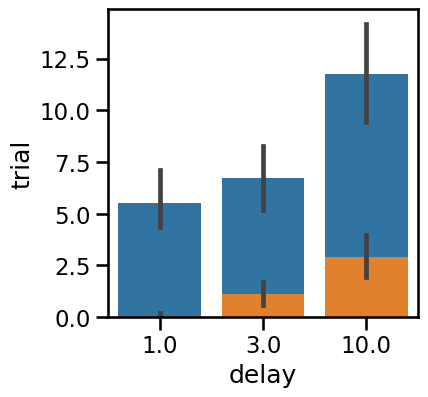

In [149]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
sns.barplot(x='delay', y='trial', data=summary)
sns.barplot(x='delay', y='reversals', data=summary)

In [ ]:
# Assuming 'value' column contains the traces you want to plot

filtered_df = filtered_df.loc[(filtered_df.delay == 10)&(filtered_df.hit == 0)]
# Identify changes in the 'trial' column
filtered_df['trial_change'] = (filtered_df['trial'] != filtered_df['trial'].shift(1)).cumsum()

# Pivot the DataFrame to get a matrix format suitable for heatmap
aggregated_df = filtered_df.groupby(['trial_change', 'times']).agg({'log_odds': 'mean'}).reset_index()

# Sort the DataFrame by the values in the column corresponding to times == 0
sorted_df = aggregated_df[aggregated_df.times == 0.375].sort_values(by='log_odds')

# Get the order of trial_change after sorting
sorted_trial_change = sorted_df['trial_change']

# Filter the original aggregated_df to keep only the sorted trial_change order
aggregated_df_sorted = aggregated_df[aggregated_df.trial_change.isin(sorted_trial_change)]

# Pivot the DataFrame to get a matrix format suitable for heatmap
heatmap_data = aggregated_df_sorted.pivot(index="trial_change", columns='times', values="log_odds")

# Reorder the heatmap_data based on the sorted trial_change
heatmap_data = heatmap_data.loc[sorted_trial_change]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, center=0, vmin=-7.5, vmax=7.5)
plt.title("Heatmap of Traces in filtered_df")
plt.show()

In [ ]:
# Initialize an empty DataFrame to store the filtered results
filtered_df = pd.DataFrame()
delay = 10
# Iterate through each row in df_filter
for _, row in df_neurons.iterrows():
    # Filter df_neurons where both columns match the current row in df_filter
    temp_df = df_cum_sti[
        (df_cum_sti['short_session'] == row['session']) &
        (df_cum_sti['trial'] == row['trial'])
    ]
    # Append the filtered results to filtered_df
    filtered_df = pd.concat([filtered_df, temp_df])

# Assuming 'value' column contains the traces you want to plot

filtered_df = filtered_df.loc[(filtered_df.delay == 3) & (filtered_df.hit == 0)]
# Identify changes in the 'trial' column
filtered_df['trial_change'] = (filtered_df['trial'] != filtered_df['trial'].shift(1)).cumsum()

# Pivot the DataFrame to get a matrix format suitable for heatmap
aggregated_df = filtered_df.groupby(['trial_change', 'times']).agg({'log_odds': 'mean'}).reset_index()

# Define the interval of times (e.g., 0.125 to 0.375)
if delay == 1:
    time_interval = [ 0.125,  0.375,  0.625,  0.875,  1.125]
elif delay == 3:
    time_interval = [ 0.125,  0.375,  0.625,  0.875,  1.125,  1.375,  1.625,  1.875,
        2.125,  2.375,  2.625,  2.875,  3.125]
else:
    time_interval = [ 0.125,  0.375,  0.625,  0.875,  1.125,  1.375,  1.625,  1.875,
            2.125,  2.375,  2.625,  2.875,  3.125,  3.375,  3.625,  3.875,
            4.125,  4.375,  4.625,  4.875,  5.125,  5.375,  5.625,  5.875,
            6.125,  6.375,  6.625,  6.875,  7.125,  7.375,  7.625,  7.875,
            8.125,  8.375,  8.625,  8.875,  9.125,  9.375,  9.625,  9.875,
        10.125]


# Calculate the proportion of positive and negative values for each trial_change within the interval
proportions = aggregated_df[aggregated_df.times.isin(time_interval)].groupby('trial_change')['log_odds'].apply(
    lambda x: (x > 0).sum() / len(x)
).reset_index().rename(columns={'log_odds': 'positive_proportion'})

# Sort the trial_change based on the positive proportion
sorted_proportions = proportions.sort_values(by='positive_proportion', ascending=False)

# Get the order of trial_change after sorting
sorted_trial_change = sorted_proportions['trial_change']

# Filter the original aggregated_df to keep only the sorted trial_change order
aggregated_df_sorted = aggregated_df[aggregated_df.trial_change.isin(sorted_trial_change)]

# Pivot the DataFrame to get a matrix format suitable for heatmap
heatmap_data = aggregated_df_sorted.pivot(index="trial_change", columns='times', values="log_odds")

# Reorder the heatmap_data based on the sorted trial_change
heatmap_data = heatmap_data.loc[sorted_trial_change]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, center=0, vmin=-7.5, vmax=7.5)
plt.title("Heatmap of Traces in filtered_df")
plt.show()

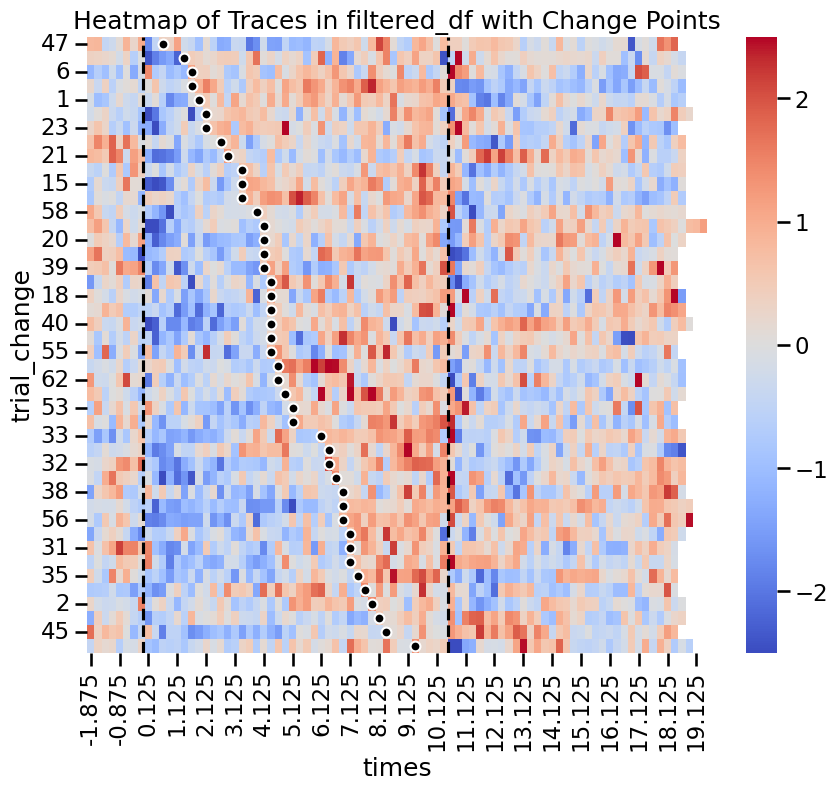

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

delay = 10
normalize = True
# Initialize an empty DataFrame to store the filtered results
filtered_df = pd.DataFrame()

# Iterate through each row in df_filter
for _, row in df_neurons.iterrows():
    # Filter df_neurons where both columns match the current row in df_filter
    temp_df = df_cum_sti[
        (df_cum_sti['short_session'] == row['session']) &
        (df_cum_sti['trial'] == row['trial'])
    ]
    # Append the filtered results to filtered_df
    filtered_df = pd.concat([filtered_df, temp_df])


# Assuming 'value' column contains the traces you want to plot
filtered_df = filtered_df.loc[(filtered_df.delay == delay) & (filtered_df.hit == 0)]

# Identify changes in the 'trial' column
filtered_df['trial_change'] = (filtered_df['trial'] != filtered_df['trial'].shift(1)).cumsum()

# Normalize the log odds in each trial if normalization is enabled
if normalize:
    filtered_df['log_odds'] = filtered_df.groupby(['trial_change'])['log_odds'].transform(lambda x: (x - x.mean()) / x.std())

# Pivot the DataFrame to get a matrix format suitable for heatmap
aggregated_df = filtered_df.groupby(['trial_change', 'times']).agg({'log_odds': 'mean'}).reset_index()

# Define the interval of times (e.g., 0.125 to 0.375)
if delay == 1:
    time_interval = [0.125, 0.375, 0.625, 0.875, 1.125]
elif delay == 3:
    time_interval = [0.125, 0.375, 0.625, 0.875, 1.125, 1.375, 1.625, 1.875,
                     2.125, 2.375, 2.625, 2.875, 3.125]
else:
    time_interval = [0.125, 0.375, 0.625, 0.875, 1.125, 1.375, 1.625, 1.875,
                     2.125, 2.375, 2.625, 2.875, 3.125, 3.375, 3.625, 3.875,
                     4.125, 4.375, 4.625, 4.875, 5.125, 5.375, 5.625, 5.875,
                     6.125, 6.375, 6.625, 6.875, 7.125, 7.375, 7.625, 7.875,
                     8.125, 8.375, 8.625, 8.875, 9.125, 9.375, 9.625, 9.875,
                     10.125]

# Filter the aggregated_df to include only the times within the interval for searching
search_df = aggregated_df[aggregated_df.times.isin(time_interval)]

# Function to find the first change point
def find_first_change_point(values, neg_count, pos_count):
    for i in range(len(values) - (neg_count + pos_count - 1)):
        if all(values[i:i+neg_count] < 0) and all(values[i+neg_count:i+neg_count+pos_count] > 0):
            return i + neg_count
    return None

# Find the first time where the change from 3 consecutive negative to 3 consecutive positive values occurs
change_points = []
for trial in search_df['trial_change'].unique():
    trial_data = search_df[search_df['trial_change'] == trial]
    values = trial_data['log_odds'].values
    point = find_first_change_point(values, 2, 3)
    if point is not None:
        change_points.append((trial, trial_data['times'].iloc[point]))

# # If no points found for 3 consecutive values, search for 2 consecutive values
# if not change_points:
#     for trial in search_df['trial_change'].unique():
#         trial_data = search_df[search_df['trial_change'] == trial]
#         values = trial_data['log_odds'].values
#         point = find_first_change_point(values, 2, 2)
#         if point is not None:
#             change_points.append((trial, trial_data['times'].iloc[point]))

# Sort the trials based on the identified transition points
sorted_trials = sorted(change_points, key=lambda x: x[1])

# Extract the sorted trial_change order
sorted_trial_change = [trial for trial, _ in sorted_trials]

# Pivot the DataFrame to get a matrix format suitable for heatmap
heatmap_data = aggregated_df.pivot(index="trial_change", columns='times', values="log_odds")

# Reorder the heatmap_data based on the sorted trial_change
heatmap_data = heatmap_data.loc[sorted_trial_change]

# Plot the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_data, center=0, vmin=-2.5, vmax=2.5, cmap='coolwarm')

# Highlight the change points
for trial, time in change_points:
    plt.scatter(heatmap_data.columns.get_loc(time) + 0.5, heatmap_data.index.get_loc(trial) + 0.5, color='black', s=50, edgecolors='white')

# Plot a vertical line at time 0
ax.axvline(x=heatmap_data.columns.get_loc(0.125) - 0.25, color='black', linestyle='--')
ax.axvline(x=heatmap_data.columns.get_loc(10.375 + 0.25), color='black', linestyle='--')

plt.title("Heatmap of Traces in filtered_df with Change Points")
plt.show()